In [164]:
import numpy as np
import perceval as pcvl
import perceval.components as comp
import sympy as sp
from perceval.components import catalog
from perceval.converters import QiskitConverter
from perceval.algorithm import Analyzer, Sampler
from perceval.rendering.circuit import SymbSkin, PhysSkin

my_circuit = pcvl.Circuit(8)

In [165]:
# list lines with phase shift
list = [1,2,3,5,6,7]
for i in list:
    my_circuit.add(i, comp.PS(sp.pi/2))

In [166]:
my_circuit.add((1, 2), comp.BS())
my_circuit.add((5, 6), comp.BS())

In [167]:
# list lines with phase shift
list = [1,5]
for i in list:
    my_circuit.add(i, comp.PS(sp.pi/2))

In [168]:
my_circuit.add((1, 2), comp.BS())
my_circuit.add((5, 6), comp.BS())

my_circuit.add((0, 1), comp.BS())
my_circuit.add((2, 3), comp.BS())
my_circuit.add((4, 5), comp.BS())
my_circuit.add((6, 7), comp.BS())

In [169]:
# list lines with phase shift
list = [0,2,4,6]
for i in list:
    my_circuit.add(i, comp.PS(sp.pi/2))

In [170]:
my_circuit.add((0, 1), comp.BS())
my_circuit.add((2, 3), comp.BS())
my_circuit.add((4, 5), comp.BS())
my_circuit.add((6, 7), comp.BS())

In [171]:

# list lines with phase shift
list = [1,5]
for i in list:
    my_circuit.add(i, comp.PS(sp.pi/2))

In [172]:
my_circuit.add((1, 2), comp.BS())
my_circuit.add((5, 6), comp.BS())

In [173]:
# list lines with phase shift
list = [1,5]
for i in list:
    my_circuit.add(i, comp.PS(sp.pi/2))

In [174]:
my_circuit.add((1, 2), comp.BS())
my_circuit.add((5, 6), comp.BS())

In [175]:
# list lines with phase shift
list = [0,2,4,6]
for i in list:
    my_circuit.add(i, comp.PS(sp.pi/2))

In [176]:
my_circuit.add((0, 1), comp.BS())
my_circuit.add((2, 3), comp.BS())
my_circuit.add((4, 5), comp.BS())
my_circuit.add((6, 7), comp.BS())

In [177]:
# list lines with phase shift
list = [0,2,4,6]
for i in list:
    my_circuit.add(i, comp.PS(sp.pi/2))

In [178]:
my_circuit.add((0, 1), comp.BS())
my_circuit.add((2, 3), comp.BS())
my_circuit.add((4, 5), comp.BS())
my_circuit.add((6, 7), comp.BS())

In [179]:
# list lines with phase shift
list = [0,1,2,4,5,6]
for i in list:
    my_circuit.add(i, comp.PS(sp.pi/2))

In [180]:
#end of generator, beginning of discriminator
# list lines with phase shift
list = [0,1,2,4,5,6]
for i in list:
    my_circuit.add(i, comp.PS(sp.pi/2))

In [181]:
my_circuit.add((0, 1), comp.BS())
my_circuit.add((2, 3), comp.BS())
my_circuit.add((4, 5), comp.BS())
my_circuit.add((6, 7), comp.BS())

In [182]:
# list lines with phase shift
list = [0,2,4,6]
for i in list:
    my_circuit.add(i, comp.PS(sp.pi/2))

In [183]:
my_circuit.add((0, 1), comp.BS())
my_circuit.add((2, 3), comp.BS())
my_circuit.add((4, 5), comp.BS())
my_circuit.add((6, 7), comp.BS())

In [184]:
my_circuit.add((1, 2), comp.BS())
my_circuit.add((5, 6), comp.BS())

In [185]:
# list lines with phase shift
list = [1,5]
for i in list:
    my_circuit.add(i, comp.PS(sp.pi/2))

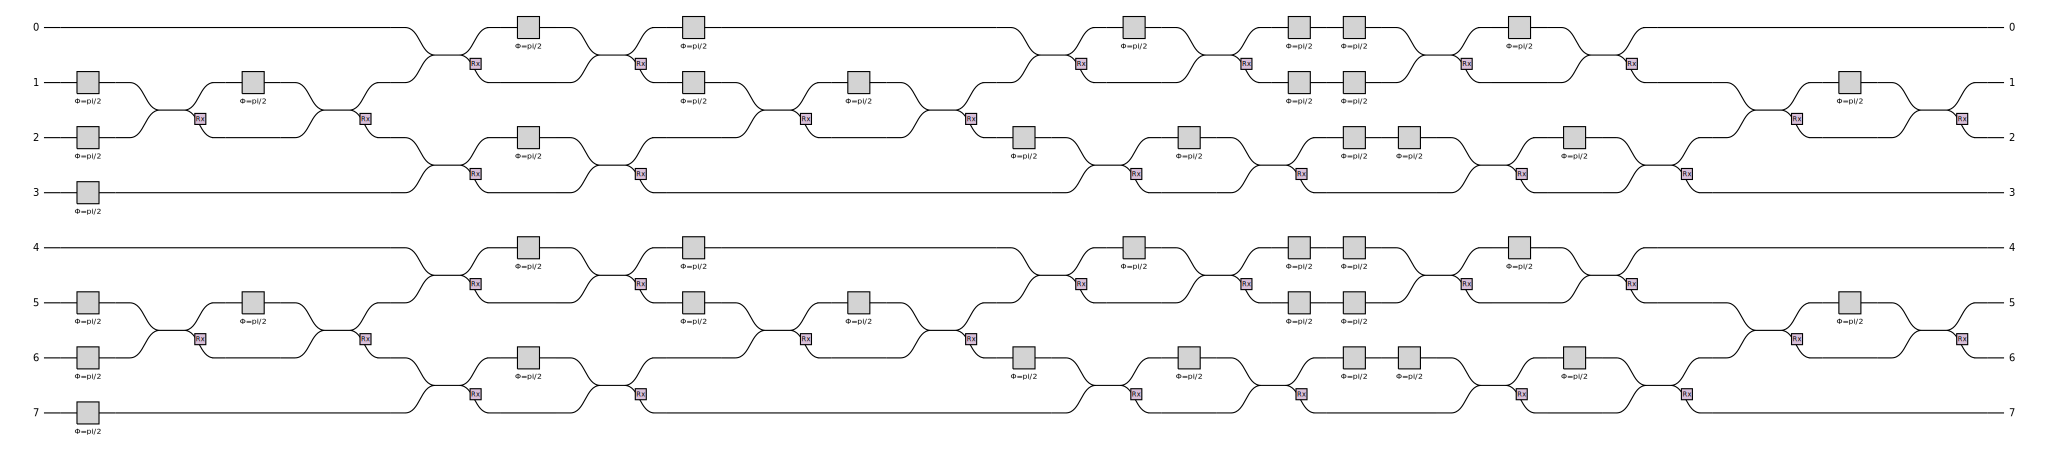

In [186]:
my_circuit.add((1, 2), comp.BS())
my_circuit.add((5, 6), comp.BS())

pcvl.pdisplay(my_circuit, skin=SymbSkin())

In [187]:
#creating the input to circuit using Perceval StateVector
sv = pcvl.StateVector("|0,0>") + pcvl.StateVector("|1,1>") + pcvl.StateVector("|2,2>") + pcvl.StateVector("|3,3>")
print(sv)bs = pcvl.StateVector("|1,0,0,0,1,0,0,0>") + pcvl.StateVector("|0,1,0,0,0,1,0,0>") + pcvl.StateVector("|0,0,1,0,0,0,1,0>") + pcvl.StateVector("|0,0,0,1,0,0,0,1>")

1/2*|2,2>+1/2*|0,0>+1/2*|3,3>+1/2*|1,1>
